# Fitting Evans2020 Experiment 1 data


In this notebook, we use PyBEAM's precoded submoudule to fit a Weibull changing threhsolds model to Evans2020's data. The citation for their publication is below:

    Evans, N. J., Hawkins, G. E., & Brown, S. D. (2020). The role of passing time in decision-making. Journal
    of Experimental Psychology: Learning, Memory, and Cognition, 46(2), 316–326. doi: 10.1037/xlm0000725. 
    
We specifically look at the Experiment 1 data from their publication. In that experiment, participants were given a random dot coherence task with four coherence conditions: 0%, 5%, 10%, and 40%. Reward rate was emphasized, with particpants instructed to maximize the number of correct decisions. Participants had a fixed time of 5 seconds in which to make the choice.

In addition to this notebook, three files located on the PyBEAM github are needed for this analysis: parseEvans2020.py, Evans2020_Exp1_data.csv, and Evans2020_Exp1_subjects.csv. We will discuss how they are used below.

First, we import PyBEAM's precoded submodule. Additionally, we import parseEvans2020.py (located on the PyBEAM github under tutorial notebooks) and numpy to handle data importing.


In [1]:
# import PyBEAM
import pybeam.precoded as pbp

# import script to parse Evans data
from parseEvans2020 import subject_rt

# import numpy to load Evans data
import numpy as np


The next block of code imports and sorts the Evans Experiment 1 data set. We first load the data (Evans2020_Exp1_data.csv) and subject numbers (Evans2020_Exp1_subjects.csv) and place them in arrays. These files are located under "tutorial notebooks" on the PyBEAM github. Data contains the participant number, choice made (correct or incorrect), coherence (0%, 5%, 10% or 40%), and reaction time. Subjects contains the list of participants.

To sort out the data for a single participant, we call the subject_rt function imported from parseEvans2020.py. It takes as inputs the data array, subjects arrays, the subject number we would like to fit, minimum rt value (filters out data below this value, as done in Evans), and the max rt value (filters out data above this value, as done in Evans).

subject_rt outputs a dictionary containing four keys: 'rt0', 'rt5', 'rt10', and 'rt40'. These contain dictionaries holding the reaction time data for each of the four coherence conditions. Each sub-dictionary contains two entries: 'rt_upper' and 'rt_lower'. 'rt_upper' contains an array of rt values corresponding to the correct choice. 'rt_lower' contains an array of values containing the rt values corresponding to an error. It outputs this particular structure becauase is the data structure required by PyBEAM's other functions.


In [2]:
# import rt data from Evans2020 Experiment 1
data = np.asarray(np.loadtxt(open("Evans2020_Exp1_data.csv", "rb"), delimiter=",", skiprows=1))

#. import subject numbers from Evans2020, choose which to fit model to
subjects = np.asarray(np.loadtxt(open("Evans2020_Exp1_subjects.csv", "rb"), delimiter=",", skiprows=1))
subject = int(subjects[2])
print(subject)

# filter data below min_rt and above max_rt
min_rt = 0.25
max_rt = 5.0

# file name to save posteriors to
file_name = 'subject_' + str(int(subject))

# return rt for desired subject number
rt = subject_rt(subject = subject, 
                   data = data, 
                 min_rt = min_rt, 
                 max_rt = max_rt)

rt


66670


{'rt0': {'rt_upper': array([1.163, 0.328, 0.606, 0.939, 1.287, 1.291, 0.538, 0.717, 1.113,
         1.017, 0.676, 1.062, 0.37 , 0.503, 0.591, 0.887, 1.099, 0.968,
         2.618, 0.565, 1.74 , 1.402, 1.457, 1.958, 0.576, 1.173, 0.725,
         1.303, 0.649, 1.155, 1.136, 0.875, 0.581, 1.627, 2.348, 0.684,
         1.191, 1.01 , 1.286, 0.989, 0.641, 0.894, 1.407, 0.908, 0.695,
         0.986, 0.801, 0.435, 0.585, 0.648]),
  'rt_lower': array([2.983, 0.903, 0.505, 1.181, 0.849, 0.268, 0.924, 0.571, 0.726,
         0.417, 0.811, 0.788, 0.805, 0.361, 0.499, 0.623, 0.669, 0.796,
         1.164, 2.709, 1.332, 1.142, 0.882, 1.885, 1.42 , 0.792, 1.244,
         0.919, 0.948, 2.478, 1.375, 1.48 , 3.305, 1.117, 0.992, 0.687,
         1.593, 0.817, 2.837, 0.745, 1.151, 0.518, 0.848, 1.738, 1.242,
         0.756, 0.751, 0.304, 0.97 , 1.119])},
 'rt5': {'rt_upper': array([0.599, 0.378, 1.093, 1.093, 0.72 , 0.837, 1.664, 2.584, 1.118,
         1.633, 0.443, 0.605, 0.495, 0.469, 0.355, 0.353, 0.44 , 

Now that we have imported our data, we now define our model. Following Evans, we use an EAM with Weibull thresholds and uniform contamination. If you are unsure how to use the model call out, see Tutorial 1 under "getting_started" on the PyBEAM github.


In [3]:
# call changing thresholds model
model = pbp.changing_thresholds(contamination = 'uniform')


Now that we have defined our model, we can define our priors, conditions, and run the inference program. Since we have four coherences, we will have four model conditions, each with their own unique drift rate prior. Each model condition has its own data set, corresponding to one of the four coherences. Following Evans, we assume that the threshold will collapse completely from its initial location, so we set the collapse parameter, c, to -1 in the priors dictionary. We also assume that the uniform contamination can occur as any time between the min and max rt values, so we set the lower and upper contaminations to be theses values.


In [4]:
# define priors
p = {'ptnd' : 'Uniform("tnd", lower = 0.0, upper = 0.75)',  # prior for non-decision time
       'pw' : 'Uniform("w", lower = 0.3, upper = 0.7)',      # prior for relative start
     'pmu0' : 'Uniform("mu0", lower = -5.0, upper = 5.0 )',  # drift rate prior for coherence 0%
     'pmu5' : 'Uniform("mu5", lower = -5.0, upper = 5.0)',   # drift rate prior for choherence 5%
    'pmu10' : 'Uniform("mu10", lower = -5.0, upper = 5.0)',  # drift rate prior for coherence 10%
    'pmu40' : 'Uniform("mu40", lower = -5.0, upper = 10.0)',  # drift rate prior for coherence 40%
       'pb' : 'Uniform("b", lower = 0.25, upper = 4.0)',     # prior for threshold location
    'plamb' : 'Uniform("lamb", lower = -1.0, upper = 2.0)',  # prior for scale parameter
   'pkappa' : 'Uniform("kappa", lower = -1.0, upper = 2.0)', # prior for shape parameter
        'c' : -1.0,                                          # collapse parameter value
       'pg' : 'Uniform("g", lower = 0.0, upper = 0.75)',     # prior for contamination strength
       'gl' : min_rt,                                        # uniform contamination lower bound
       'gu' : max_rt}                                        # uniform contamination upper bound

# model condition for coherence 0%
c0 = {'rt' : rt['rt0'],
     'tnd' : 'ptnd',
       'w' : 'pw',
      'mu' : 'pmu0',
       'b' : 'pb',
    'lamb' : 'plamb',
   'kappa' : 'pkappa',
       'c' : 'c',
       'g' : 'pg',
      'gl' : 'gl',
      'gu' : 'gu'}

# model condition for coherence 5%
c5 = {'rt' : rt['rt5'],
     'tnd' : 'ptnd',
       'w' : 'pw',
      'mu' : 'pmu5',
       'b' : 'pb',
    'lamb' : 'plamb',
   'kappa' : 'pkappa',
       'c' : 'c',
       'g' : 'pg',
      'gl' : 'gl',
      'gu' : 'gu'}

# model condition for coherence 10%
c10 = {'rt' : rt['rt10'],
       'tnd' : 'ptnd',
         'w' : 'pw',
        'mu' : 'pmu10',
         'b' : 'pb',
      'lamb' : 'plamb',
     'kappa' : 'pkappa',
         'c' : 'c',
         'g' : 'pg',
        'gl' : 'gl',
        'gu' : 'gu'}

# model condition for coherence 40%
c40 = {'rt' : rt['rt40'],
      'tnd' : 'ptnd',
        'w' : 'pw',
       'mu' : 'pmu40',
        'b' : 'pb',
     'lamb' : 'plamb',
    'kappa' : 'pkappa',
        'c' : 'c',
        'g' : 'pg',
       'gl' : 'gl',
       'gu' : 'gu'}

# load conditions into dictionary
cond = {0 : c0, 1 : c5, 2 : c10, 3 : c40}

# run parameter inference
idata = pbp.inference(model = model,
                     priors = p,
                 conditions = cond,
                    samples = 75000,
                     chains = 3,
                      cores = 3,
                  file_name = file_name)


Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [tnd, w, mu0, mu5, mu10, mu40, b, lamb, kappa, g]


Sampling 3 chains for 0 tune and 75_000 draw iterations (0 + 225_000 draws total) took 365 seconds.


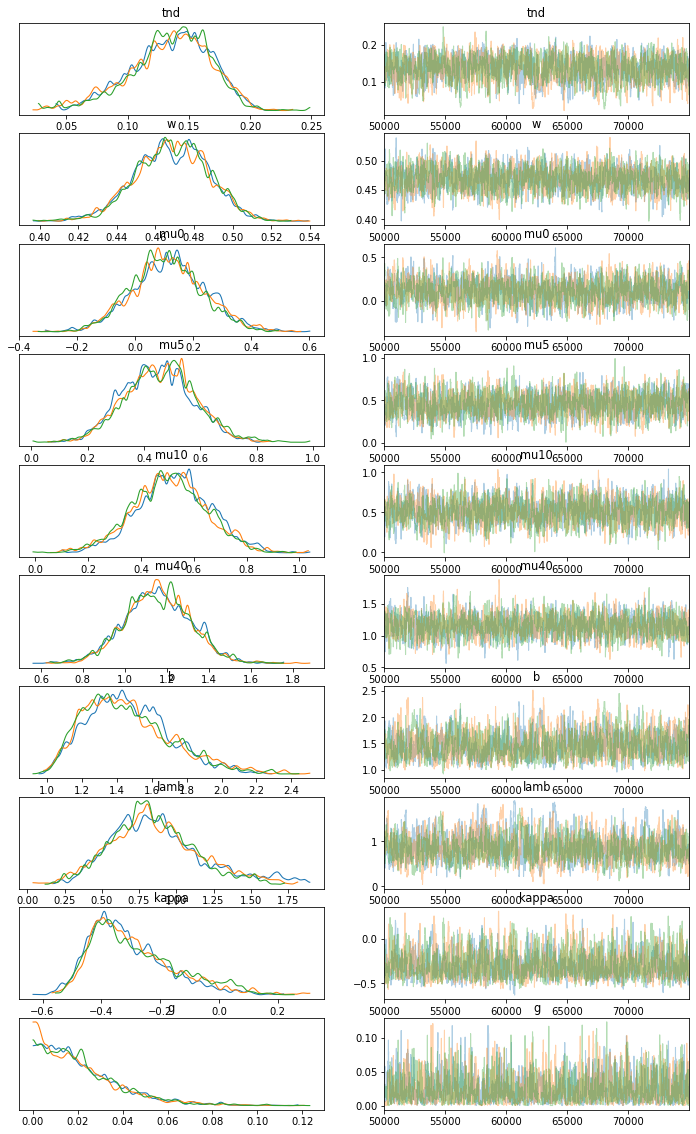

In [5]:
# plot posteriors
pbp.plot_idata(file_name = file_name, burnin = 50000);


In [6]:
# posterior summary statistics
pbp.summary(file_name = file_name, burnin = 50000)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tnd,0.135,0.033,0.069,0.190,0.001,0.001,680.0,893.0,1.01
w,0.469,0.019,0.434,0.503,0.001,0.000,1098.0,1901.0,1.00
mu0,0.113,0.124,-0.119,0.344,0.004,0.003,1143.0,1973.0,1.00
mu5,0.455,0.124,0.218,0.675,0.004,0.003,1146.0,2082.0,1.01
mu10,0.515,0.139,0.254,0.779,0.004,0.003,1049.0,1966.0,1.00
mu40,1.156,0.157,0.873,1.454,0.005,0.003,1175.0,2019.0,1.00
b,1.463,0.245,1.043,1.909,0.010,0.007,611.0,960.0,1.01
lamb,0.856,0.300,0.314,1.468,0.014,0.010,513.0,479.0,1.01
kappa,-0.295,0.143,-0.520,-0.011,0.005,0.004,847.0,1580.0,1.00
g,0.022,0.018,0.000,0.054,0.000,0.000,1026.0,1077.0,1.00
